In [1]:
import tensorflow as tf

#from tensorflow.python.keras.preprocessing import image 
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

In [2]:
from tensorflow.python.keras.applications import vgg19

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array

In [6]:
%matplotlib inline

In [7]:
vgg_mean = [123.68, 116.779, 103.939]

In [8]:
    # This is the path to the image you want to transform.
content_path = "content2.jpg"
# This is the path to the style image.
style_path = "style2.jpg"

# Dimensions of the generated picture.
width, height = load_img(content_path).size
img_height = 400
img_width = int(width * img_height / height)
print(width)
print(height)

800
533


In [9]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img


In [10]:
vgg_mean

[123.68, 116.779, 103.939]

In [11]:
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_height, img_width))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_height, img_width, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += vgg_mean[2]
    x[:, :, 1] += vgg_mean[1]
    x[:, :, 2] += vgg_mean[0]
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [12]:
K.image_data_format()

'channels_last'

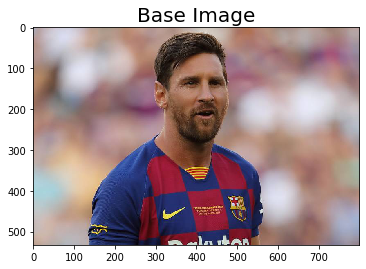

In [13]:
plt.figure()
plt.title("Base Image",fontsize=20)
img1 = load_img(content_path)
plt.imshow(img1)

In [14]:
content_layers = ['block4_conv2'] 

# Style layers
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

In [15]:
weight_path = "vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [16]:
def create_vgg_model():
    model=vgg19.VGG19(include_top=False,weights= weight_path )
    model.trainable=False
    content_layer=content_layers
    style_layer = style_layers
    output_layers=[model.get_layer(layer).output for layer in (content_layer + style_layer)]
    return tf.keras.models.Model(model.input,output_layers)

In [17]:
processed_content_image= tf.Variable(preprocess_image(content_path))
processed_style_image= tf.Variable(preprocess_image(style_path))

In [18]:
processed_content_image

<tf.Variable 'Variable:0' shape=(1, 400, 600, 3) dtype=float32, numpy=
array([[[[82.061   , 55.221   , 49.32    ],
         [82.061   , 55.221   , 50.32    ],
         [80.061   , 54.221   , 49.32    ],
         ...,
         [50.060997, 41.221   , 58.32    ],
         [50.060997, 41.221   , 58.32    ],
         [49.060997, 40.221   , 57.32    ]],

        [[82.061   , 55.221   , 49.32    ],
         [81.061   , 54.221   , 49.32    ],
         [80.061   , 54.221   , 49.32    ],
         ...,
         [50.060997, 41.221   , 58.32    ],
         [50.060997, 41.221   , 58.32    ],
         [50.060997, 41.221   , 58.32    ]],

        [[81.061   , 54.221   , 49.32    ],
         [80.061   , 54.221   , 49.32    ],
         [79.061   , 53.221   , 48.32    ],
         ...,
         [53.060997, 42.221   , 59.32    ],
         [52.060997, 41.221   , 58.32    ],
         [52.060997, 41.221   , 58.32    ]],

        ...,

        [[43.060997, 44.221   , 65.32    ],
         [44.060997, 45.221   ,

In [19]:

model=create_vgg_model()

In [20]:
#model.summary()

In [21]:
def get_content_loss(new_image_content,base_image_content):
    return tf.reduce_mean(tf.square(new_image_content-base_image_content))

In [22]:
def get_gram_matrix(output):
    channels=output.shape[-1]
    a=tf.reshape(output,[-1,channels])
    gram_matrix=tf.matmul(a,a,transpose_a=True)
    n=int(gram_matrix.shape[0])
    return gram_matrix/tf.cast(n,'float32'), n

In [23]:
def get_style_loss(new_image_style,base_style):
    new_style_gram,new_gram_height=get_gram_matrix(new_image_style)
    base_style_gram,base_gram_height=get_gram_matrix(base_style)
     
    gram_features=int(new_style_gram.shape[0])
    gram_channels=int(new_style_gram.shape[-1])
    loss=tf.reduce_mean(tf.square(base_style_gram-new_style_gram)/(2*int(new_gram_height)*(gram_features)*(gram_channels))**2)
    return loss

In [24]:
def total_loss(new_image_output,base_content_output,base_style_output,alpha=0.001,beta=1):
    new_image_styles=new_image_output[len(content_layers):]
    base_image_styles=base_style_output[len(content_layers):]
    style_loss=0
    n=len(new_image_styles)
    for i in range(n):
        style_loss+=get_style_loss(new_image_styles[i],base_image_styles[i])
    new_image_contents=new_image_output[:len(content_layers)]
    base_image_contents=base_content_output[:len(content_layers)]
    content_loss=0
    n=len(new_image_contents)
    for i in range(n):
        content_loss+=get_content_loss(new_image_contents[i],base_image_contents[i])/n
    return alpha*content_loss+ beta*style_loss

In [25]:
base_style_outputs=model(processed_style_image)
base_content_outputs=model(processed_content_image)
generated_image=tf.Variable(processed_content_image+tf.random.normal(processed_content_image.shape))
optimizer=tf.optimizers.Adam(learning_rate=5)

In [26]:
def optimize(iterations):
    images=[]
    losses=[]
    best_loss=20000000
    best_image=generated_image.numpy()
    for i in range(iterations):
        with tf.GradientTape() as tape:
            print("Iteration ",i)
            tape.watch(generated_image) ## Keep Eye on our generated image and optimize its values
            generated_image_content=model(generated_image) ## get output from model for generated image
            loss=total_loss(generated_image_content,base_content_outputs,base_style_outputs) ## find total loss of images
            losses.append(loss.numpy())
            gradient=tape.gradient(loss,generated_image)
            optimizer.apply_gradients(zip([gradient],[generated_image]))
            generated_image_clipped=tf.clip_by_value(generated_image, 0, 255) ## Clip image to be in range 0-255
            generated_image.assign(generated_image_clipped) ## assign clipped value of to generated_image variable
            print("LOSS= {0}".format(loss.numpy()))
            if i%10==0:
                images.append(deprocess_image(generated_image.numpy()))
            if loss<best_loss:
                best_image=generated_image.numpy()
                best_loss=loss
    return best_image,images,losses

In [27]:
result,images,losses=optimize(10)


Iteration  0
LOSS= 336.60003662109375
Iteration  1
LOSS= 594.596435546875
Iteration  2
LOSS= 568.914794921875
Iteration  3
LOSS= 546.5494384765625
Iteration  4
LOSS= 527.6067504882812
Iteration  5
LOSS= 512.6866455078125
Iteration  6
LOSS= 499.5259704589844
Iteration  7
LOSS= 487.7037353515625
Iteration  8
LOSS= 476.89306640625
Iteration  9
LOSS= 466.93804931640625


In [28]:
result1 = deprocess_image(result)

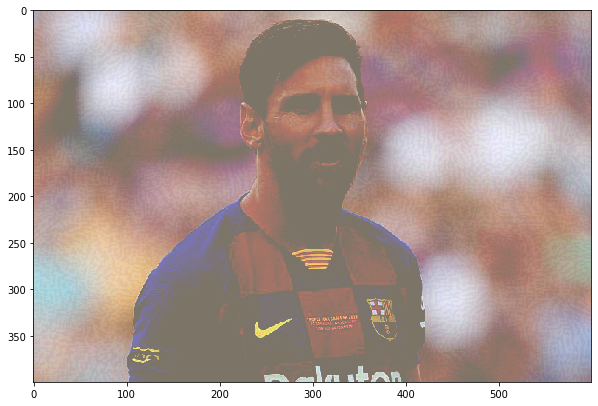

In [29]:
plt.figure(figsize=(10,10))
plt.imshow(result1)

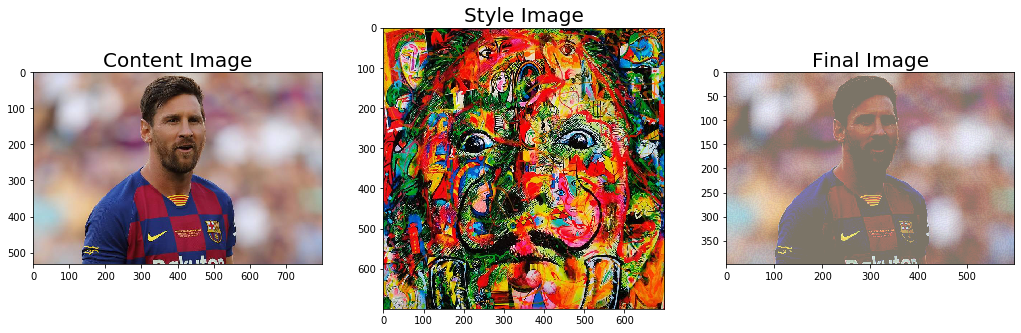

In [30]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
plt.title("Content Image",fontsize=20)
img_cont = load_img(content_path)
plt.imshow(img_cont)

plt.subplot(5,5,1+1)
plt.title("Style Image",fontsize=20)
img_style = load_img(style_path)
plt.imshow(img_style)

plt.subplot(5,5,1+2)
plt.title("Final Image",fontsize=20)
plt.imshow(result1)

In [32]:
result2,images2,losses2=optimize(200)

Iteration  0
LOSS= 457.5969543457031
Iteration  1
LOSS= 448.781494140625
Iteration  2
LOSS= 440.4405517578125
Iteration  3
LOSS= 432.41168212890625
Iteration  4
LOSS= 424.6353759765625
Iteration  5
LOSS= 417.08807373046875
Iteration  6
LOSS= 409.76434326171875
Iteration  7
LOSS= 402.62286376953125
Iteration  8
LOSS= 395.6300964355469
Iteration  9
LOSS= 388.7751770019531
Iteration  10
LOSS= 382.09893798828125
Iteration  11
LOSS= 375.5933837890625
Iteration  12
LOSS= 369.22772216796875
Iteration  13
LOSS= 363.02880859375
Iteration  14
LOSS= 356.99609375
Iteration  15
LOSS= 351.1524658203125
Iteration  16
LOSS= 345.5084533691406
Iteration  17
LOSS= 340.07391357421875
Iteration  18
LOSS= 334.8714904785156
Iteration  19
LOSS= 329.9063720703125
Iteration  20
LOSS= 325.1949462890625
Iteration  21
LOSS= 320.7322998046875
Iteration  22
LOSS= 316.5360107421875
Iteration  23
LOSS= 312.60247802734375
Iteration  24
LOSS= 308.9243469238281
Iteration  25
LOSS= 305.493896484375
Iteration  26
LOSS= 302

In [34]:
result2 = deprocess_image(result2)

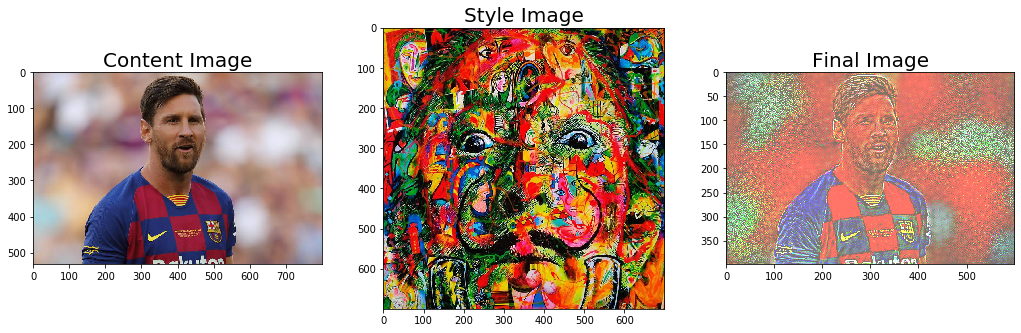

In [35]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
plt.title("Content Image",fontsize=20)
img_cont = load_img(content_path)
plt.imshow(img_cont)

plt.subplot(5,5,1+1)
plt.title("Style Image",fontsize=20)
img_style = load_img(style_path)
plt.imshow(img_style)

plt.subplot(5,5,1+2)
plt.title("Final Image",fontsize=20)
plt.imshow(result2)